In [1]:
import numpy as np
from scipy.integrate import quad
import emcee
import matplotlib.pyplot as plt
import corner
from tqdm import tqdm

### Data and Parameters

In [2]:
# Redshift (z)
z_data = np.array([0.9, 1.2, 1.5])

# Angular diameter distances and errors [Mpc]
dA_data = np.array([1688, 1781, 1793])
dA_err  = np.array([47, 46, 28])

# Hubble parameter and errors [km/s/Mpc]
H_data = np.array([112.1, 136.9, 154.7])
H_err  = np.array([3.8,   5.7,   6.0])

In [3]:
c = 299792.458          # speed of light [km/s]
H0 = 67                 # Hubble constant [km/s/Mpc]
Omega_m = 0.319         # Omega matter
Omega_de = 1 - Omega_m  # Omega dark energy

## flat-LambdaCDM comparison

In [4]:


# Hubble Parameter
def hubble_lambdaCDM(z, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de):
    H=H0*np.sqrt(Omega_m *(1+z)**3 + Omega_de)
    return H

# Angular diameter distance
def angular_diameter_distance_lambdaCDM(z_array, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de, c=c):
    def integrand(zp, H0, Omega_m, Omega_de):
        return c / hubble_lambdaCDM(zp, H0, Omega_m, Omega_de)

    results = []
    for z in np.atleast_1d(z_array):
        integral, _ = quad(integrand, 0, z, args=(H0, Omega_m, Omega_de))
        dA = integral / (1 + z)
        results.append(dA)

    return np.array(results)

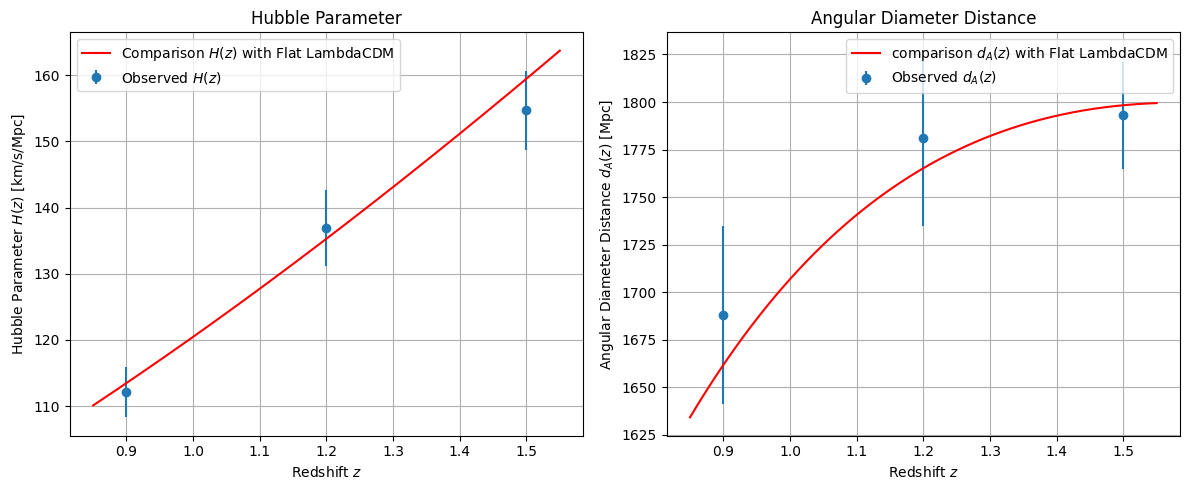

In [5]:
# Best-fit parameters



z = np.linspace(min(z_data) - 0.05, max(z_data) + 0.05, 300)

# Evaluate model on dense grid
H = hubble_lambdaCDM(z)
dA= angular_diameter_distance_lambdaCDM(z)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# H(z)
ax1.errorbar(z_data, H_data, yerr=H_err, fmt='o', label="Observed $H(z)$")
ax1.plot(z, H, '-', color='red', label="Comparison $H(z)$ with Flat LambdaCDM")
ax1.set_xlabel("Redshift $z$")
ax1.set_ylabel("Hubble Parameter $H(z)$ [km/s/Mpc]")
ax1.set_title("Hubble Parameter")
ax1.legend()
ax1.grid(True)

# d_A(z)
ax2.errorbar(z_data, dA_data, yerr=dA_err, fmt='o', label="Observed $d_A(z)$")
ax2.plot(z, dA, '-', color='red', label="comparison $d_A(z)$ with Flat LambdaCDM")
ax2.set_xlabel("Redshift $z$")
ax2.set_ylabel("Angular Diameter Distance $d_A(z)$ [Mpc]")
ax2.set_title("Angular Diameter Distance")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [6]:
chi2_H = np.sum(((H_data - hubble_lambdaCDM(z_data)) / H_err) ** 2)
chi2_dA = np.sum(((dA_data - angular_diameter_distance_lambdaCDM(z_data)) / dA_err) ** 2)
print(f"Chi-squared for Hubble Parameter: {chi2_H:.2f}")
print(f"Chi-squared for Angular Diameter Distance: {chi2_dA:.2f}")

#now they are separate, later these two funciton will be summed, that's why it will be bigger

Chi-squared for Hubble Parameter: 0.85
Chi-squared for Angular Diameter Distance: 0.47


## Markov Chain Monte Carlo

### Omega-matter fixed

Functions to calculate H and $d_A$

In [7]:
def get_Omega_de(Omega_m_1):
    return 1 - Omega_m_1


# Hubble Parameter
def hubble(z, w0, wa, H0, Omega_m, Omega_de):
    term1 = Omega_m * (1 + z)**3
    exponent = 3 * (1 + w0 + wa)
    term2 = Omega_de * (1 + z)**exponent * np.exp(-3 * wa * z / (1 + z))
    return H0 * np.sqrt(term1 + term2)

# Angular diameter distance
def angular_diameter_distance(z_array, w0, wa, H0, Omega_m, Omega_de, c):
    def integrand(zp, w0, wa, H0, Omega_m, Omega_de):
        return c / hubble(zp, w0, wa, H0, Omega_m, Omega_de)

    results = []
    for z in np.atleast_1d(z_array):
        integral, _ = quad(integrand, 0, z, args=(w0, wa, H0, Omega_m, Omega_de))
        dA = integral / (1 + z)
        results.append(dA)

    return np.array(results)

# Get functions that only take as arguments the parameters we actually want to optimize over
hubble_fit_func = lambda z, w0, wa: hubble(z=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de)
dA_fit_func     = lambda z, w0, wa: angular_diameter_distance(z_array=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de, c=c)

Define functions needed for MCMC

In [8]:
def log_likelihood(theta):
    w0, wa = theta
    H_model = hubble_fit_func(z_data, w0, wa)
    dA_model = dA_fit_func(z_data, w0, wa)

    chi2_H = np.sum(((H_data - H_model) / H_err) ** 2)
    chi2_dA = np.sum(((dA_data - dA_model) / dA_err) ** 2)

    return -0.5 * (chi2_H + chi2_dA)

# Define prior (uniform distribution within search area)
def log_prior(theta):
    w0, wa = theta
    if -5 < w0 < 1 and -6 < wa < 5: # search area
        return 0.0  # flat prior = constant log prior
    return -np.inf  # log(0), SET TO 0 FOR UNBOUNDED SEARCH

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

Run MCMC

In [9]:
# Params
ndim = 2
nwalkers = 32
nsteps = 500

# Initial guess
p0 = np.array([-1.0, 0.0])
initial_positions = p0 + 1e-2 * np.random.randn(nwalkers, ndim)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(initial_positions, nsteps, progress=True)

100%|██████████| 500/500 [00:01<00:00, 393.28it/s]


State([[-0.83235792 -1.07303567]
 [-1.20961766  0.9108476 ]
 [-1.20689833  0.78846213]
 [-0.98118372 -0.95591317]
 [-1.03159181 -0.3532484 ]
 [-1.10741529  0.15610008]
 [-1.44634479  1.66301182]
 [-0.64953142 -1.57339052]
 [-0.39533223 -3.47047753]
 [-0.33268553 -3.51058304]
 [-0.53533083 -2.59241272]
 [-1.02247623 -0.37062144]
 [-0.64177528 -1.65632226]
 [-0.83896961 -0.63148137]
 [-1.04270063 -0.09754558]
 [-0.11252685 -4.08621134]
 [-0.48054234 -2.47441743]
 [-0.70662969 -1.21732168]
 [-0.75171698 -0.66582092]
 [-1.25672572  1.0194718 ]
 [-1.31055147  1.08466802]
 [-0.865743   -0.77973529]
 [-0.81428564 -1.3636418 ]
 [-1.10167702  0.37783121]
 [-1.37086719  1.34299956]
 [-0.80005948 -1.57503523]
 [-1.13884027  0.4440248 ]
 [-0.66341423 -1.55275169]
 [-0.4696703  -2.79434605]
 [-1.06341472  0.00601145]
 [-1.0572279   0.15185997]
 [-0.696507   -1.73109893]], log_prob=[-0.93259074 -1.13904129 -0.91636027 -3.76293613 -1.48822063 -0.90717048
 -2.22770316 -1.23693455 -3.12978421 -2.695562

Get results and plot them. Use median $\pm$ credible interval (most common in astro/cosmo)

w0 = -0.889 (+0.307/-0.281)
wa = -0.668 (+1.220/-1.447)


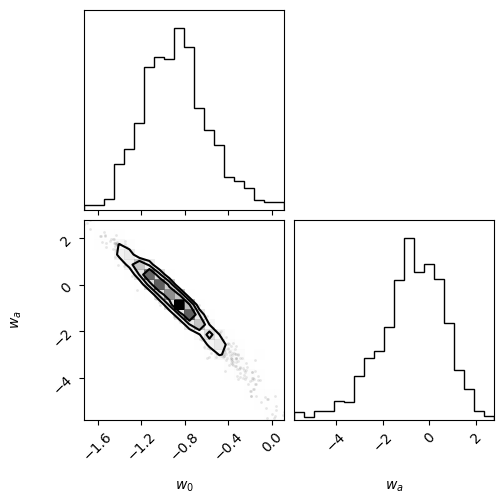

In [10]:
samples = sampler.get_chain(discard=100, thin=10, flat=True)

w0_16, w0_50, w0_84 = np.percentile(samples[:, 0], [16, 50, 84])
wa_16, wa_50, wa_84 = np.percentile(samples[:, 1], [16, 50, 84])

print(f"w0 = {w0_50:.3f} (+{w0_84 - w0_50:.3f}/-{w0_50 - w0_16:.3f})")
print(f"wa = {wa_50:.3f} (+{wa_84 - wa_50:.3f}/-{wa_50 - wa_16:.3f})")

fig = corner.corner(samples, labels=[r"$w_0$", r"$w_a$"], truths=[None, None])
plt.show()

Plot results of fit

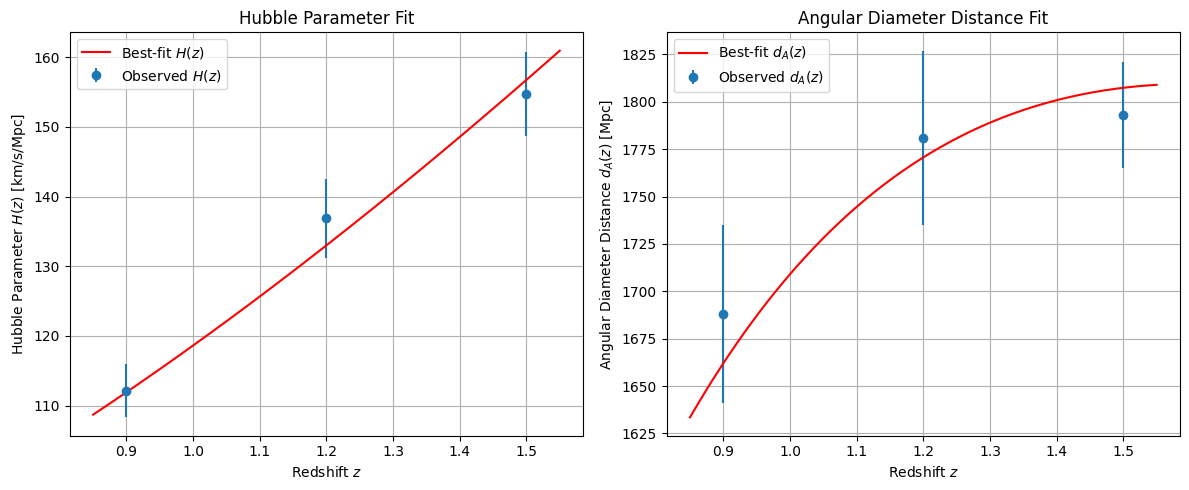

In [11]:
# Best-fit parameters
w0_best, wa_best = np.median(samples, axis=0)

# Dense redshift sampling for smooth curves
z_dense = np.linspace(min(z_data) - 0.05, max(z_data) + 0.05, 300)

# Evaluate model on dense grid
H_model_dense = hubble_fit_func(z_dense, w0_best, wa_best)
dA_model_dense = dA_fit_func(z_dense, w0_best, wa_best)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# H(z)
ax1.errorbar(z_data, H_data, yerr=H_err, fmt='o', label="Observed $H(z)$")
ax1.plot(z_dense, H_model_dense, '-', color='red', label="Best-fit $H(z)$")
ax1.set_xlabel("Redshift $z$")
ax1.set_ylabel("Hubble Parameter $H(z)$ [km/s/Mpc]")
ax1.set_title("Hubble Parameter Fit")
ax1.legend()
ax1.grid(True)

# d_A(z)
ax2.errorbar(z_data, dA_data, yerr=dA_err, fmt='o', label="Observed $d_A(z)$")
ax2.plot(z_dense, dA_model_dense, '-', color='red', label="Best-fit $d_A(z)$")
ax2.set_xlabel("Redshift $z$")
ax2.set_ylabel("Angular Diameter Distance $d_A(z)$ [Mpc]")
ax2.set_title("Angular Diameter Distance Fit")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
samples = sampler.get_chain(discard=100, thin=10, flat=True)

# MEDIAN POSTERIOR
w0_med, wa_med = np.median(samples, axis=0)

H_model_med = hubble_fit_func(z_data, w0_med, wa_med)
dA_model_med = dA_fit_func(z_data, w0_med, wa_med)

chi2_H_med = np.sum(((H_data - H_model_med) / H_err)**2)
chi2_dA_med = np.sum(((dA_data - dA_model_med) / dA_err)**2)
chi2_total_med = chi2_H_med + chi2_dA_med

# MOST PROBABLE SET OF PARAMETERS
log_probs = np.array([log_posterior(p) for p in samples])
best_index = np.argmax(log_probs)
w0_map, wa_map = samples[best_index]

H_model_map = hubble_fit_func(z_data, w0_map, wa_map)
dA_model_map = dA_fit_func(z_data, w0_map, wa_map)
chi2_map = np.sum(((H_data - H_model_map) / H_err)**2) + np.sum(((dA_data - dA_model_map) / dA_err)**2)

# MIN CHI-SQUARE SAMPLE (find sample with lowest chi-square)
def chi2_total(params):
    w0, wa = params
    H_model = hubble_fit_func(z_data, w0, wa)
    dA_model = dA_fit_func(z_data, w0, wa)
    chi2_H = np.sum(((H_data - H_model) / H_err)**2)
    chi2_dA = np.sum(((dA_data - dA_model) / dA_err)**2)
    return chi2_H + chi2_dA

chi2s = np.array([chi2_total(p) for p in samples])
min_index = np.argmin(chi2s)
w0_best_chi2, wa_best_chi2 = samples[min_index]sß
chi2_min = chi2s[min_index]

# Center of posterior distribution
print("Median Posterior:")
print(f"  w0 = {w0_med:.3f}, wa = {wa_med:.3f}, chi² = {chi2_total_med:.2f}")

# Most probable set of parameters
print("\nMAP (max posterior):")
print(f"  w0 = {w0_map:.3f}, wa = {wa_map:.3f}, chi² = {chi2_map:.2f}")

print("\nMin Chi² Sample:")
print(f"  w0 = {w0_best_chi2:.3f}, wa = {wa_best_chi2:.3f}, chi² = {chi2_min:.2f}")

Median Posterior:
  w0 = -0.889, wa = -0.668, chi² = 1.21

MAP (max posterior):
  w0 = -0.981, wa = -0.195, chi² = 1.06

Min Chi² Sample:
  w0 = -0.981, wa = -0.195, chi² = 1.06


### Omega-matter variable

In [13]:
hubble_fit_func_4 = lambda z, w0, wa, Omega_m_1, Omega_de_1: hubble(z=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de)
dA_fit_func_4     = lambda z, w0, wa, Omega_m_1, Omega_de_1: angular_diameter_distance(z_array=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de, c=c)

In [14]:
def log_likelihood_4(theta):
    w0, wa, Omega_m_1 = theta
    H_model = hubble_fit_func_4(z_data, w0, wa, Omega_m_1, get_Omega_de(Omega_m_1))
    dA_model = dA_fit_func_4(z_data, w0, wa, Omega_m_1, get_Omega_de(Omega_m_1))

    chi2_H = np.sum(((H_data - H_model) / H_err) ** 2)
    chi2_dA = np.sum(((dA_data - dA_model) / dA_err) ** 2)

    return -0.5 * (chi2_H + chi2_dA)

# Define prior (uniform distribution within search area)
def log_prior_4(theta):
    w0, wa, Omega_m_1 = theta
    if -5 < w0 < 1 and -6 < wa < 5 and 0.1< Omega_m_1 < 1.1: # search area
        return 0.0  # flat prior = constant log prior
    return -np.inf  # log(0), SET TO 0 FOR UNBOUNDED SEARCH

def log_posterior_4(theta):
    lp = log_prior_4(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_4(theta)

In [15]:
# Params
ndim = 3
nwalkers = 32
nsteps = 500

# Initial guess
p0 = np.array([-1.0, 0.0, 0.7])
initial_positions = p0 + 1e-2 * np.random.randn(nwalkers, ndim)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_4)
sampler.run_mcmc(initial_positions, nsteps, progress=True)

100%|██████████| 500/500 [00:01<00:00, 464.76it/s]


State([[-1.29315342  1.0657      0.87185111]
 [-0.92444244 -0.38923773  1.01328125]
 [-0.89294112 -0.536611    0.74147928]
 [-1.03405107  0.27244419  1.08239448]
 [-1.32463179  1.48999424  0.97754486]
 [-0.60311704 -2.55296268  0.75267496]
 [-1.12228058  0.39982011  0.84193704]
 [-0.38347472 -2.70216981  0.25278722]
 [-1.09251319  0.42052046  0.91762242]
 [-0.83084451 -1.31446003  0.1818896 ]
 [-1.00543154 -0.0731516   1.03005067]
 [-0.90746819 -0.18023665  0.4930894 ]
 [-0.62635775 -2.04311807  0.56105551]
 [-0.74692715 -1.33201674  0.11830984]
 [-0.77626582 -1.18494997  1.08302419]
 [-0.76640918 -1.43620697  0.60264585]
 [-0.46830658 -3.0106265   0.19802379]
 [-1.24604787  1.03171074  0.22562591]
 [-0.80858876 -0.64763947  0.15439908]
 [-0.79502787 -0.9437219   0.10886527]
 [-0.80087019 -0.90051981  1.068876  ]
 [-1.1803819   0.47211285  0.59297412]
 [-0.49989519 -2.08145584  0.71402666]
 [-0.97059024 -0.49186986  0.90552293]
 [-0.98529713  0.2497931   0.96575771]
 [-0.32809453 -3.14

w0 = -0.895 (+0.311/-0.288)
wa = -0.615 (+1.252/-1.448)
Omega_m_1 = 0.620 (+0.336/-0.371)


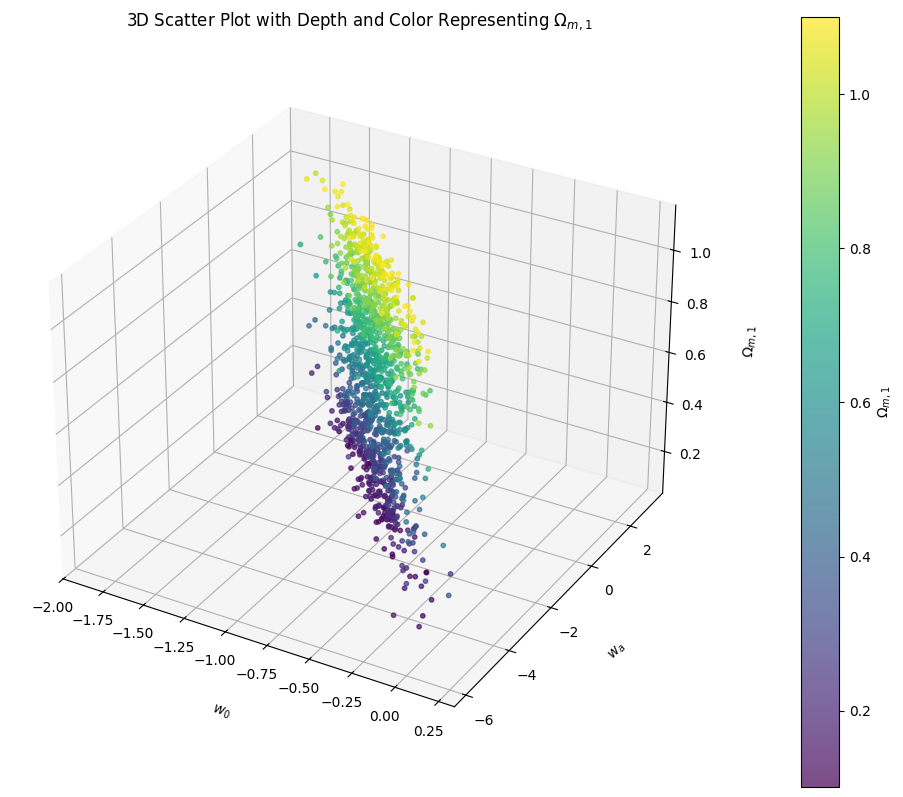

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Extract the samples
samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Compute percentiles for w0, wa, and Omega_m_1
w0_16, w0_50, w0_84 = np.percentile(samples[:, 0], [16, 50, 84])
wa_16, wa_50, wa_84 = np.percentile(samples[:, 1], [16, 50, 84])
Omega_m_1_16, Omega_m_1_50, Omega_m_1_84 = np.percentile(samples[:, 2], [16, 50, 84])

# Print results
print(f"w0 = {w0_50:.3f} (+{w0_84 - w0_50:.3f}/-{w0_50 - w0_16:.3f})")
print(f"wa = {wa_50:.3f} (+{wa_84 - wa_50:.3f}/-{wa_50 - wa_16:.3f})")
print(f"Omega_m_1 = {Omega_m_1_50:.3f} (+{Omega_m_1_84 - Omega_m_1_50:.3f}/-{Omega_m_1_50 - Omega_m_1_16:.3f})")

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the samples with color representing Omega_m_1
sc = ax.scatter(
    samples[:, 0], samples[:, 1], samples[:, 2],
    c=samples[:, 2], cmap='viridis', s=10, alpha=0.7, depthshade=True
)

# Add a colorbar to indicate the scale of Omega_m_1
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label(r"$\Omega_{m,1}$")

# Label the axes
ax.set_xlabel(r"$w_0$", labelpad=15)
ax.set_ylabel(r"$w_a$", labelpad=15)
ax.set_zlabel(r"$\Omega_{m,1}$", labelpad=15)

# Add a title
ax.set_title("3D Scatter Plot with Depth and Color Representing $\Omega_{m,1}$", pad=20)

# Show the plot
plt.show()

w0 = -0.895 (+0.311/-0.288)
wa = -0.615 (+1.252/-1.448)
Omega_m_1 = 0.620 (+0.336/-0.371)


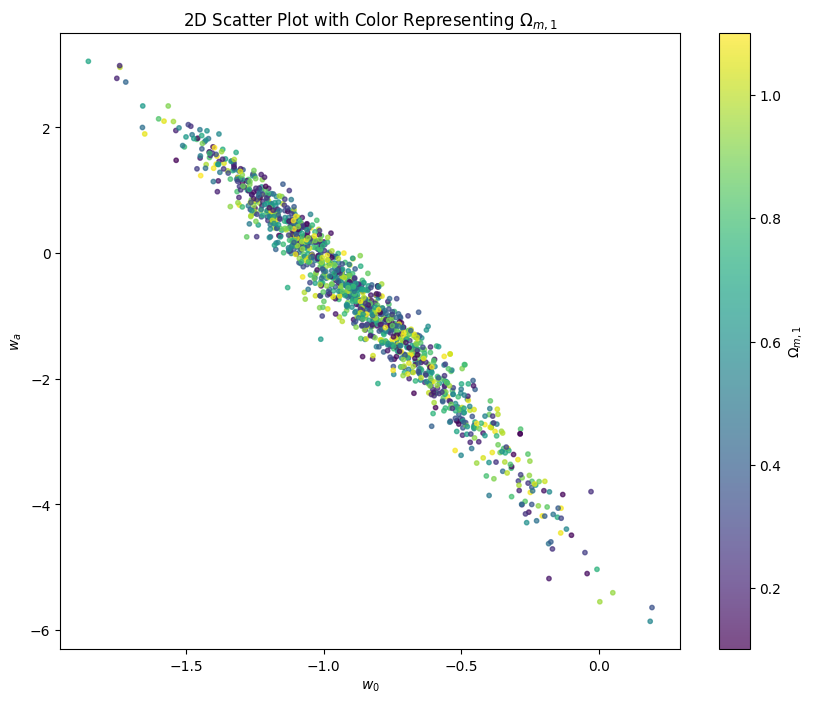

In [17]:
import matplotlib.pyplot as plt

# Extract the samples
samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Compute percentiles for w0, wa, and Omega_m_1
w0_16, w0_50, w0_84 = np.percentile(samples[:, 0], [16, 50, 84])
wa_16, wa_50, wa_84 = np.percentile(samples[:, 1], [16, 50, 84])
Omega_m_1_16, Omega_m_1_50, Omega_m_1_84 = np.percentile(samples[:, 2], [16, 50, 84])

# Print results
print(f"w0 = {w0_50:.3f} (+{w0_84 - w0_50:.3f}/-{w0_50 - w0_16:.3f})")
print(f"wa = {wa_50:.3f} (+{wa_84 - wa_50:.3f}/-{wa_50 - wa_16:.3f})")
print(f"Omega_m_1 = {Omega_m_1_50:.3f} (+{Omega_m_1_84 - Omega_m_1_50:.3f}/-{Omega_m_1_50 - Omega_m_1_16:.3f})")

# Create a 2D scatter plot with color representing Omega_m_1
plt.figure(figsize=(10, 8))
sc = plt.scatter(samples[:, 0], samples[:, 1], c=samples[:, 2], cmap='viridis', s=10, alpha=0.7)

# Add a colorbar to show the scale of Omega_m_1
cbar = plt.colorbar(sc)
cbar.set_label(r"$\Omega_{m,1}$")

# Label the axes
plt.xlabel(r"$w_0$")
plt.ylabel(r"$w_a$")
plt.title("2D Scatter Plot with Color Representing $\Omega_{m,1}$")

# Show the plot
plt.show()